# Removing Trends - Lab

## Introduction

In this lab, you'll practice your detrending skills!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Detrending the Airpassenger data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
# Import passengers.csv and set it as a time-series object. Plot the TS

df = pd.read_csv('passengers.csv')
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d')
df.set_index('Month', inplace=True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


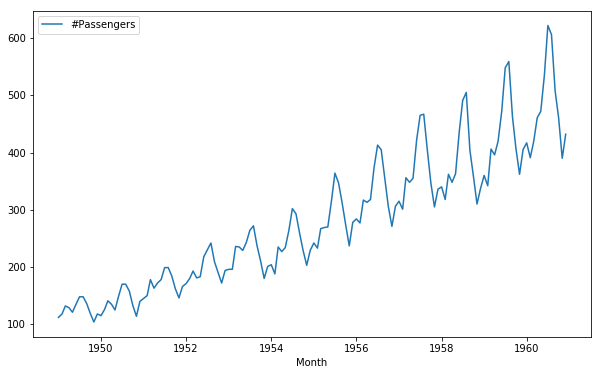

In [2]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df.index,df['#Passengers'], label='#Passengers')
ax.set_xlabel('Month')
ax.legend()
plt.show();

## Create a stationarity check

At this stage, we can use the code from previous labs to create a function `stationarity_check(ts)` that takes in a time series object and performs stationarity checks including rolling statistics and the Dickey Fuller test. 

We want the output of the function to:
- Plot the original time series along with the rolling mean and rolling standard deviation in one plot
- Output the results of the Dickey-Fuller test

In [3]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
# Collect and package the code from previous lab
def plot_tests(data,col='#Passengers',label='Month',window=12):
    
    #Find rolling mean and rolling std
    roll = data[col].rolling(window=window)
    roll_std = roll.std()
    roll_mean = roll.mean()
    
    #plot rolling
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(data.index, data[col], label='# of Passengers')
    ax.plot(data.index, roll_mean, label="Rolling Mean")
    ax.plot(data.index, roll_std, label="Rolling Std")
    ax.set_xlabel(label)
    ax.set_title('Rolling Mean & Std Deviation')
    ax.legend()
    plt.show()
    
    #run df test
    dftest = adfuller(data[col])
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                    'p-value',
                                    '##Lags Used', 
                                    'Number of Obeservations Used',
                                   ])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Use your newly created function on the airpassenger data set.

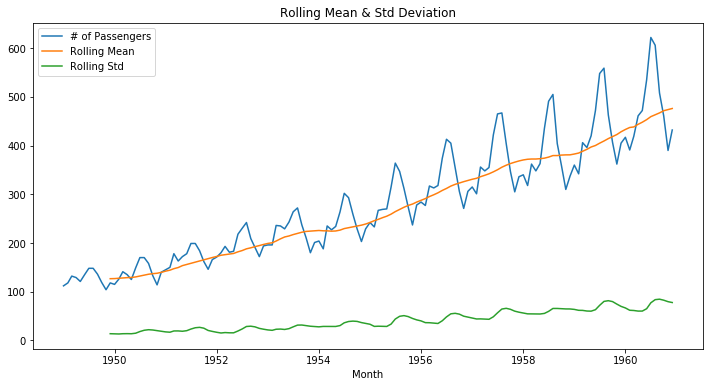

Test Statistic                    0.815369
p-value                           0.991880
##Lags Used                      13.000000
Number of Obeservations Used    130.000000
Critical Value (1%)              -3.481682
Critical Value (5%)              -2.884042
Critical Value (10%)             -2.578770
dtype: float64


In [4]:
plot_tests(df,'#Passengers','Month')

## Perform a log() and sqrt() transform

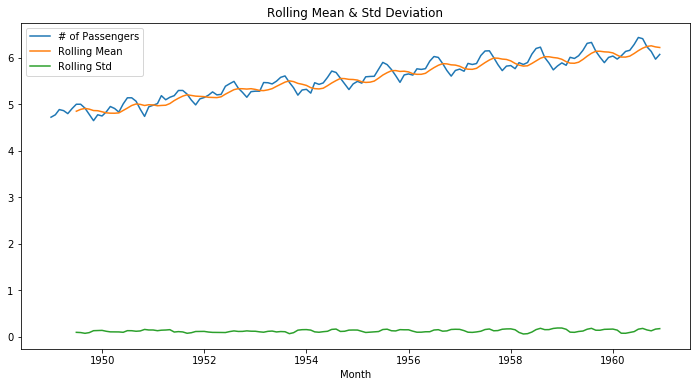

Test Statistic                   -1.717017
p-value                           0.422367
##Lags Used                      13.000000
Number of Obeservations Used    130.000000
Critical Value (1%)              -3.481682
Critical Value (5%)              -2.884042
Critical Value (10%)             -2.578770
dtype: float64


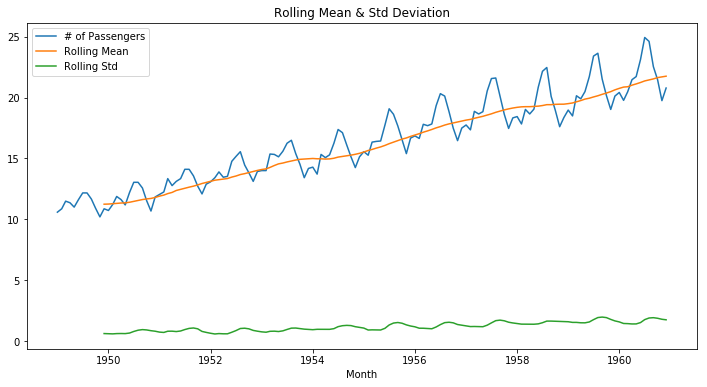

Test Statistic                   -0.345854
p-value                           0.918754
##Lags Used                      13.000000
Number of Obeservations Used    130.000000
Critical Value (1%)              -3.481682
Critical Value (5%)              -2.884042
Critical Value (10%)             -2.578770
dtype: float64


In [5]:
# Log transform timeseries and compare with original to check the effect
log_data = pd.Series(np.log(df['#Passengers']),index=df.index)
sqrt_data = pd.Series(np.sqrt(df['#Passengers']), index=df.index)
plot_tests(pd.DataFrame(log_data),window=7)
plot_tests(pd.DataFrame(sqrt_data))

moving forward, let's keep working with the log transformed data before subtracting rolling mean, differencing, etc.

## Subtracting the rolling mean

Create a rolling mean using your log transformed time series, with a time window of 7. Plot the log-transformed time series and the rolling mean together.

In [6]:
log_roll_mean = log_data.rolling(window = 7).mean()


Now, subtract the rolling mean from the time series, look at the 10 first elements of the result and plot the result.

In [7]:
# Subtract the moving average from the original data and check head for Nans
sub_roll_mean = log_data - log_roll_mean
sub_roll_mean.head()

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
Name: #Passengers, dtype: float64

In [10]:
# Drop the NaN values from timeseries calculated above
sub_roll_mean = sub_roll_mean.dropna()

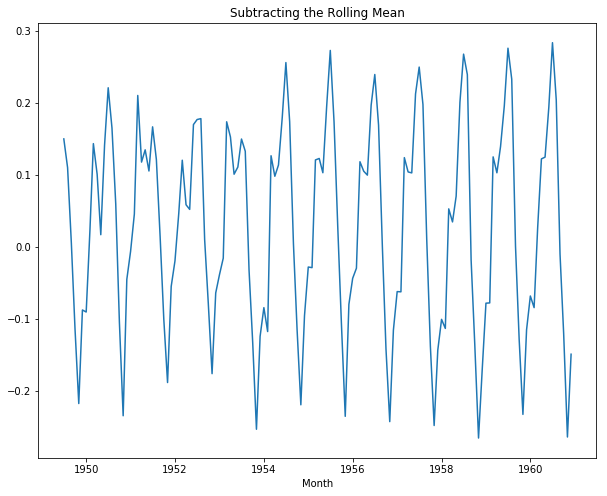

In [12]:
# Plot the result
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(sub_roll_mean.index, sub_roll_mean)
ax.set_title('Subtracting the Rolling Mean')
ax.set_xlabel('Month')
plt.show()

Finally, use your function `check_stationarity` to see if this series is considered stationary!

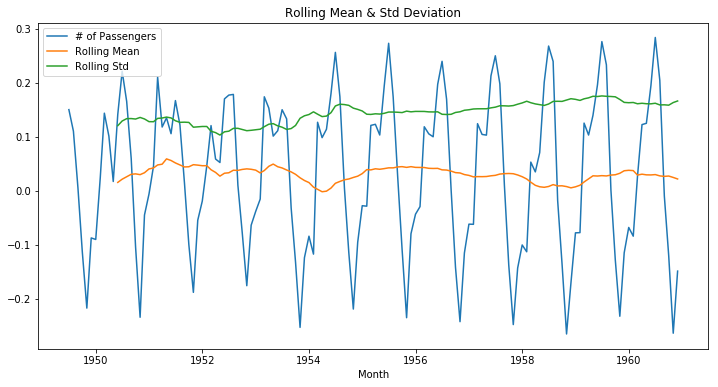

Test Statistic                   -2.348027
p-value                           0.156946
##Lags Used                      14.000000
Number of Obeservations Used    123.000000
Critical Value (1%)              -3.484667
Critical Value (5%)              -2.885340
Critical Value (10%)             -2.579463
dtype: float64


In [15]:
plot_tests(pd.DataFrame(sub_roll_mean),window=12)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


## Subtracting the weighted rolling mean

Repeat all the above for the *weighter* rolling mean. Start from the log-transformed data again. Compare the Dickey-Fuller Test results. What do you conclude?

In [17]:
type(log_data)

pandas.core.series.Series

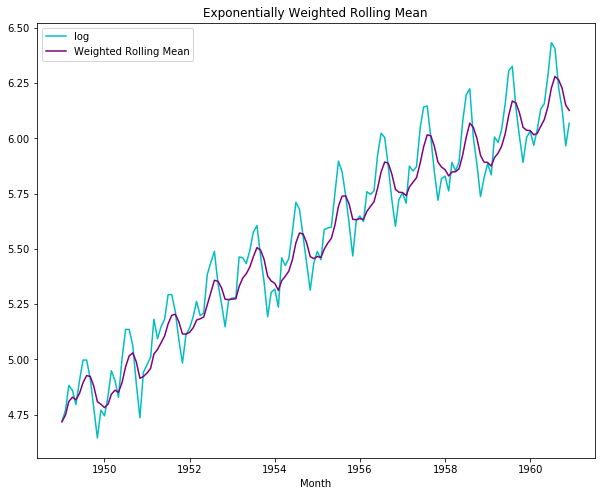

In [19]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
exp_data = log_data.ewm(halflife=2).mean()
# Plot the original data with exp weighted average

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(log_data, color='c', label='log')
ax.plot(exp_data, color='purple', label='Weighted Rolling Mean')
ax.legend()
ax.set_xlabel('Month')
ax.set_title('Exponentially Weighted Rolling Mean')
plt.show()

In [11]:
# Subtract the moving average from the original data and plot
sub_wrm = log_data - exp_data
sub_wrm = sub_wrm.dropna()

fig,ax = plt.subplots(figsize=(10,8))
ax.plot(sub_wrm, color='purple')
ax.set_xlabel('Month')
ax.set_title('Subtract')

In [12]:
# do a stationarity check

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


## Differencing

Using exponentially weighted moving averages, we seem to have removed the upward trend, but not the seasonality issue. Now use differencing to remove seasonality. Make sure you use the right amount of `periods`. Start from the log-transformed, exponentially weighted rolling mean-subtracted series.

After you differenced the series, run the `stationarity check` again.

In [13]:
# difference your data and look at the head

In [14]:
# plot your differenced time series

In [15]:
# drop nas

In [16]:
# perform the stationarity check

### Your conclusion

## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing.